In [149]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [150]:
data = pd.read_csv("./mlp_regression_data.csv");
X, y = data[["x"]].values, data["y"];

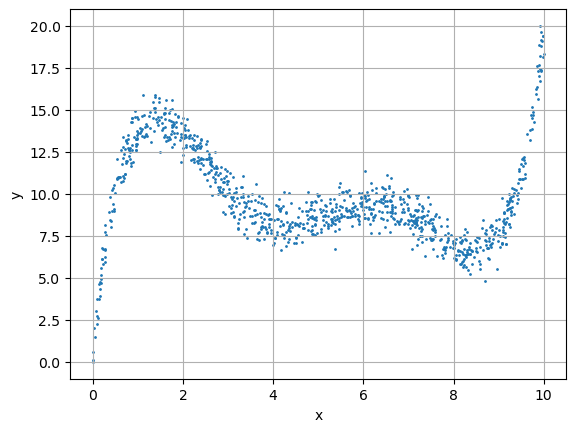

In [151]:
plt.scatter(X, y, s=1);
plt.xlabel("x");
plt.ylabel("y");
plt.grid();
plt.show();

In [152]:
class MLP(torch.nn.Module):
    def __init__(
            self, 
            numFeatures=1, 
            numClasses=1,
            activation=torch.nn.Sigmoid() # Default can be changed
        ):
        super().__init__();

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(numFeatures, 400),
            activation,

            # 2nd hidden layer
            torch.nn.Linear(400, 250),
            activation,

            # 3rd hidden layer
            torch.nn.Linear(250, 80),
            activation,
            
            # Output layer
            torch.nn.Linear(80, numClasses)
        );

    def forward(self, x):
        logits = self.all_layers(x);
        return logits;

In [153]:
class MLPDataSet(Dataset):
    def __init__(self, X, y):
        self.features = torch.tensor(X, dtype=torch.float32);
        self.labels = torch.tensor(y, dtype=torch.float32);

    def __getitem__(self, index):
        x = self.features[index];
        y = self.labels[index];
        return x, y;

    def __len__(self):
        return self.features.shape[0];

# Computing the z-score Standardization
X_mean = np.mean(X, axis=0);
y_mean = np.mean(y, axis=0);
X_std = np.std(X, axis=0);
y_std = np.std(y, axis=0);

norm_X = (X - X_mean) / X_std;
norm_y = (y - y_mean) / y_std;

trainDataSet = MLPDataSet(norm_X, norm_y);

In [154]:
torch.manual_seed(123);

def trainModel(model, dataLoader, epochs, learningRate):
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate);

    losses = [];
    for epoch in range(epochs):
        model.train();
        epochLoss = 0.0;

        for features, labels in dataLoader:
            features = features.view(-1, 1);
            labels = labels.view(-1, 1);

            predictions = model(features);
            loss = F.mse_loss(predictions, labels);

            optimizer.zero_grad();
            loss.backward();
            optimizer.step();

            epochLoss += loss.item();
        
        epochLoss /= len(dataLoader); # average the loss
        losses.append(epochLoss);
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epochLoss:.4f}");

    return losses;

In [155]:
def plotLossCurve(losses, title):
    plt.plot(losses);
    plt.title("Loss vs. Epochs: " + title);
    plt.xlabel("Epoch");
    plt.ylabel("Loss");
    plt.grid();
    plt.show();

In [156]:
def plotRegressionCurve(model, title):
    tensor = torch.tensor(norm_X, dtype=torch.float32);

    # Denormalize for plotting
    predictions = model.forward(tensor).detach() * y_std + y_mean;

    sortedIndices = tensor.flatten().argsort();
    sorted_X = X[sortedIndices];
    sortedPredictions = predictions[sortedIndices];

    plt.plot(sorted_X, sortedPredictions, color="red", label="Predictions");
    plt.title("Regression Curve: " + title);
    plt.scatter(X, y, color="blue", label="Actual data", s=1);
    plt.xlabel("X");
    plt.ylabel("y");
    plt.legend();
    plt.grid();
    plt.show();

In [157]:
def hyperParamSearch(dataSet, batchSizes, learningRates, numEpochs):
    bestLoss = np.inf;
    bestParams = {};

    for batchSize in batchSizes:
        for learningRate in learningRates:
            print(f'Training with num_epochs={numEpochs}, batch_size={batchSize}, learning_rate={learningRate}');

            trainLoader = DataLoader(
                dataset=dataSet,
                batch_size=batchSize,
                shuffle=True
            );

            model = MLP(numFeatures=1, numClasses=1, activation=torch.nn.ReLU());
            losses = trainModel(model, trainLoader, epochs=numEpochs, learningRate=learningRate);
    
            lastLoss = losses[-1];
            if lastLoss < bestLoss:
                bestLoss = lastLoss;
                bestParams = {
                    "num_epochs": numEpochs,
                    "batch_size": batchSize,
                    "learning_rate": learningRate,
                    "losses": losses,
                    "model": model
                };

            print(f"Total loss after training with num_epochs: {numEpochs}, batch_size: {batchSize}, "
                f"learning_rate: {learningRate} is: {lastLoss:.4f}");

            graphTitle = f"Batch size: {batchSize}, Learning rate: {learningRate}, Epochs: {numEpochs}";
            plotLossCurve(losses, graphTitle);
            plotRegressionCurve(model, graphTitle);
    
    return bestParams;

Training with num_epochs=100, batch_size=32, learning_rate=0.01
Epoch 1/100, Loss: 1.0114
Epoch 2/100, Loss: 0.6103
Epoch 3/100, Loss: 0.3672
Epoch 4/100, Loss: 0.4837
Epoch 5/100, Loss: 0.1717
Epoch 6/100, Loss: 0.1514
Epoch 7/100, Loss: 0.1012
Epoch 8/100, Loss: 0.1082
Epoch 9/100, Loss: 0.0995
Epoch 10/100, Loss: 0.1513
Epoch 11/100, Loss: 0.2126
Epoch 12/100, Loss: 0.1482
Epoch 13/100, Loss: 0.0951
Epoch 14/100, Loss: 0.0936
Epoch 15/100, Loss: 0.0939
Epoch 16/100, Loss: 0.1169
Epoch 17/100, Loss: 0.0962
Epoch 18/100, Loss: 0.0950
Epoch 19/100, Loss: 0.0878
Epoch 20/100, Loss: 0.0867
Epoch 21/100, Loss: 0.0848
Epoch 22/100, Loss: 0.0822
Epoch 23/100, Loss: 0.0889
Epoch 24/100, Loss: 0.0872
Epoch 25/100, Loss: 0.1065
Epoch 26/100, Loss: 0.1359
Epoch 27/100, Loss: 0.1015
Epoch 28/100, Loss: 0.1631
Epoch 29/100, Loss: 0.1163
Epoch 30/100, Loss: 0.1109
Epoch 31/100, Loss: 0.0882
Epoch 32/100, Loss: 0.0804
Epoch 33/100, Loss: 0.0854
Epoch 34/100, Loss: 0.0864
Epoch 35/100, Loss: 0.0899


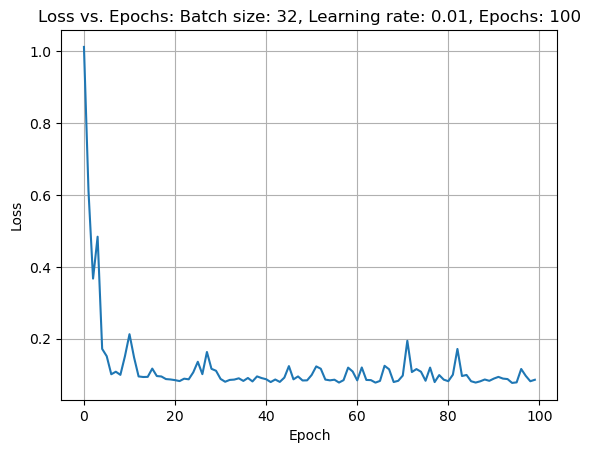

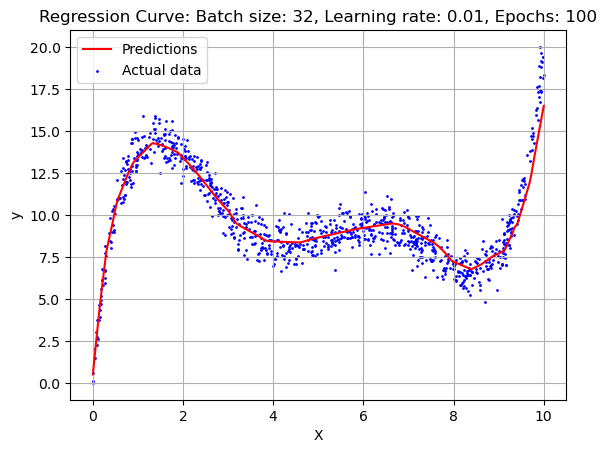

Training with num_epochs=100, batch_size=32, learning_rate=0.001
Epoch 1/100, Loss: 0.8151
Epoch 2/100, Loss: 0.6296
Epoch 3/100, Loss: 0.4213
Epoch 4/100, Loss: 0.2569
Epoch 5/100, Loss: 0.2313
Epoch 6/100, Loss: 0.1357
Epoch 7/100, Loss: 0.1125
Epoch 8/100, Loss: 0.1028
Epoch 9/100, Loss: 0.0929
Epoch 10/100, Loss: 0.1115
Epoch 11/100, Loss: 0.0907
Epoch 12/100, Loss: 0.1009
Epoch 13/100, Loss: 0.1036
Epoch 14/100, Loss: 0.1027
Epoch 15/100, Loss: 0.0882
Epoch 16/100, Loss: 0.0909
Epoch 17/100, Loss: 0.0899
Epoch 18/100, Loss: 0.0793
Epoch 19/100, Loss: 0.0842
Epoch 20/100, Loss: 0.0999
Epoch 21/100, Loss: 0.0900
Epoch 22/100, Loss: 0.0809
Epoch 23/100, Loss: 0.0949
Epoch 24/100, Loss: 0.0807
Epoch 25/100, Loss: 0.0801
Epoch 26/100, Loss: 0.0802
Epoch 27/100, Loss: 0.0829
Epoch 28/100, Loss: 0.0921
Epoch 29/100, Loss: 0.0876
Epoch 30/100, Loss: 0.1050
Epoch 31/100, Loss: 0.1025
Epoch 32/100, Loss: 0.0866
Epoch 33/100, Loss: 0.0980
Epoch 34/100, Loss: 0.0796
Epoch 35/100, Loss: 0.0808

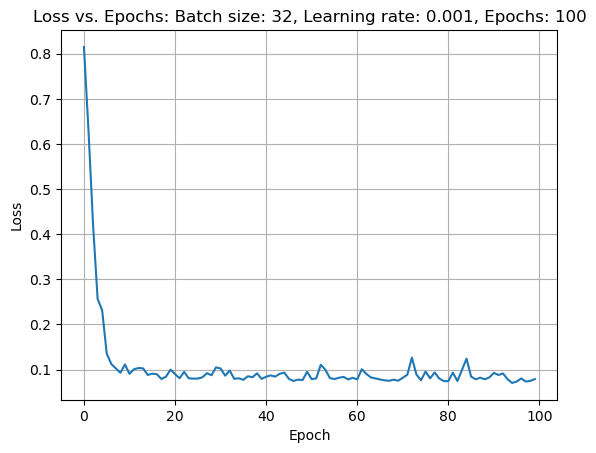

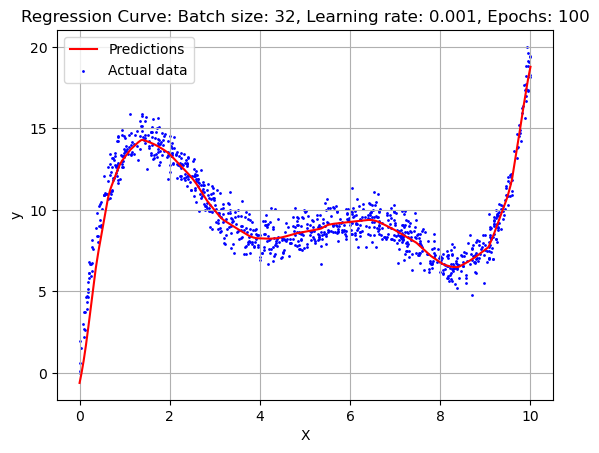

Training with num_epochs=100, batch_size=32, learning_rate=0.0001
Epoch 1/100, Loss: 0.8950
Epoch 2/100, Loss: 0.8225
Epoch 3/100, Loss: 0.7823
Epoch 4/100, Loss: 0.7541
Epoch 5/100, Loss: 0.6867
Epoch 6/100, Loss: 0.6511
Epoch 7/100, Loss: 0.6105
Epoch 8/100, Loss: 0.5860
Epoch 9/100, Loss: 0.5412
Epoch 10/100, Loss: 0.4964
Epoch 11/100, Loss: 0.4558
Epoch 12/100, Loss: 0.4014
Epoch 13/100, Loss: 0.3687
Epoch 14/100, Loss: 0.3325
Epoch 15/100, Loss: 0.2927
Epoch 16/100, Loss: 0.2665
Epoch 17/100, Loss: 0.2361
Epoch 18/100, Loss: 0.2327
Epoch 19/100, Loss: 0.1951
Epoch 20/100, Loss: 0.1947
Epoch 21/100, Loss: 0.1709
Epoch 22/100, Loss: 0.1522
Epoch 23/100, Loss: 0.1487
Epoch 24/100, Loss: 0.1370
Epoch 25/100, Loss: 0.1250
Epoch 26/100, Loss: 0.1196
Epoch 27/100, Loss: 0.1090
Epoch 28/100, Loss: 0.1059
Epoch 29/100, Loss: 0.1022
Epoch 30/100, Loss: 0.1017
Epoch 31/100, Loss: 0.0978
Epoch 32/100, Loss: 0.1022
Epoch 33/100, Loss: 0.0912
Epoch 34/100, Loss: 0.0916
Epoch 35/100, Loss: 0.093

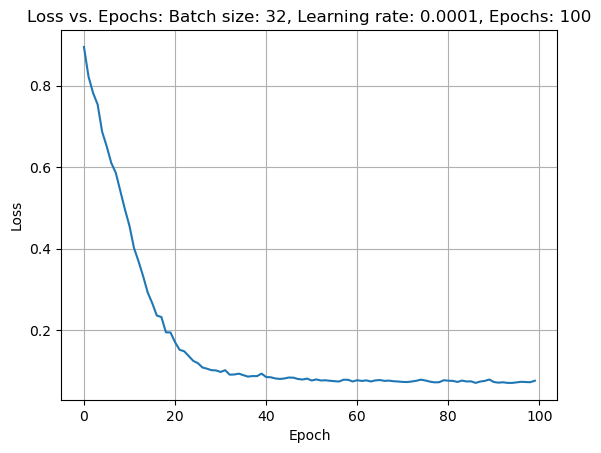

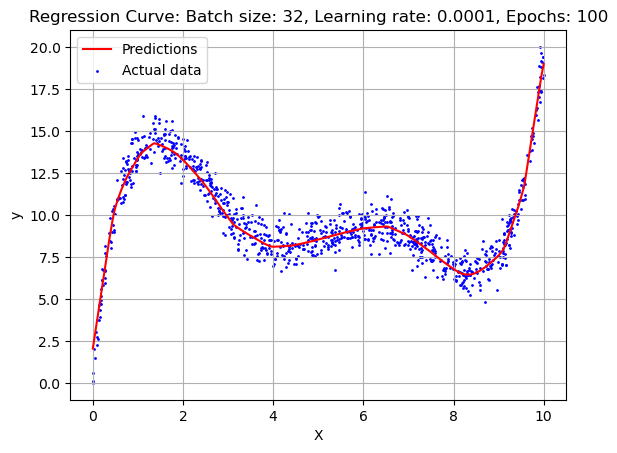

Training with num_epochs=100, batch_size=64, learning_rate=0.01
Epoch 1/100, Loss: 1.1572
Epoch 2/100, Loss: 0.6588
Epoch 3/100, Loss: 0.3226
Epoch 4/100, Loss: 0.2691
Epoch 5/100, Loss: 0.1590
Epoch 6/100, Loss: 0.1182
Epoch 7/100, Loss: 0.1046
Epoch 8/100, Loss: 0.1131
Epoch 9/100, Loss: 0.0965
Epoch 10/100, Loss: 0.0889
Epoch 11/100, Loss: 0.0936
Epoch 12/100, Loss: 0.0961
Epoch 13/100, Loss: 0.0996
Epoch 14/100, Loss: 0.0813
Epoch 15/100, Loss: 0.0870
Epoch 16/100, Loss: 0.0777
Epoch 17/100, Loss: 0.0790
Epoch 18/100, Loss: 0.0925
Epoch 19/100, Loss: 0.0851
Epoch 20/100, Loss: 0.0854
Epoch 21/100, Loss: 0.1573
Epoch 22/100, Loss: 0.1425
Epoch 23/100, Loss: 0.1130
Epoch 24/100, Loss: 0.1251
Epoch 25/100, Loss: 0.0975
Epoch 26/100, Loss: 0.1051
Epoch 27/100, Loss: 0.0827
Epoch 28/100, Loss: 0.0848
Epoch 29/100, Loss: 0.0987
Epoch 30/100, Loss: 0.0886
Epoch 31/100, Loss: 0.0938
Epoch 32/100, Loss: 0.1186
Epoch 33/100, Loss: 0.1233
Epoch 34/100, Loss: 0.0835
Epoch 35/100, Loss: 0.0832


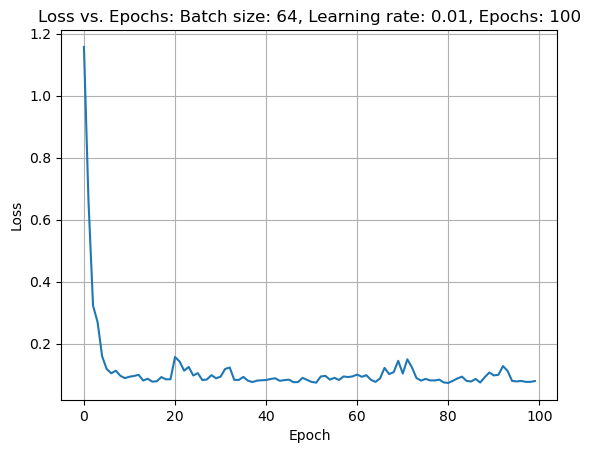

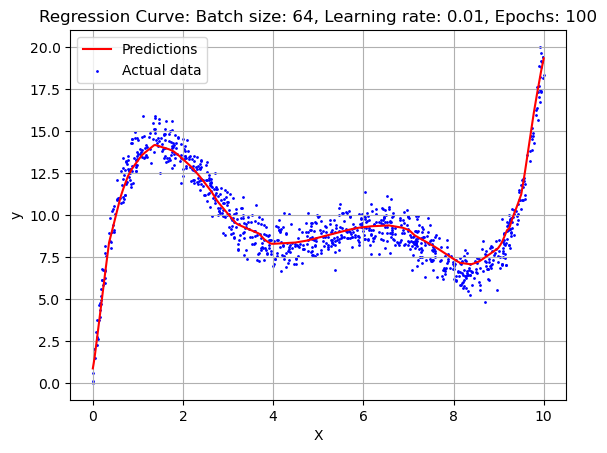

Training with num_epochs=100, batch_size=64, learning_rate=0.001
Epoch 1/100, Loss: 0.8665
Epoch 2/100, Loss: 0.7500
Epoch 3/100, Loss: 0.6665
Epoch 4/100, Loss: 0.6013
Epoch 5/100, Loss: 0.4893
Epoch 6/100, Loss: 0.3529
Epoch 7/100, Loss: 0.2513
Epoch 8/100, Loss: 0.2058
Epoch 9/100, Loss: 0.1531
Epoch 10/100, Loss: 0.1253
Epoch 11/100, Loss: 0.1132
Epoch 12/100, Loss: 0.1032
Epoch 13/100, Loss: 0.1188
Epoch 14/100, Loss: 0.1150
Epoch 15/100, Loss: 0.1128
Epoch 16/100, Loss: 0.1041
Epoch 17/100, Loss: 0.0899
Epoch 18/100, Loss: 0.0917
Epoch 19/100, Loss: 0.1059
Epoch 20/100, Loss: 0.1010
Epoch 21/100, Loss: 0.1076
Epoch 22/100, Loss: 0.0904
Epoch 23/100, Loss: 0.0919
Epoch 24/100, Loss: 0.0925
Epoch 25/100, Loss: 0.0896
Epoch 26/100, Loss: 0.0885
Epoch 27/100, Loss: 0.0894
Epoch 28/100, Loss: 0.0799
Epoch 29/100, Loss: 0.0798
Epoch 30/100, Loss: 0.0838
Epoch 31/100, Loss: 0.0844
Epoch 32/100, Loss: 0.0822
Epoch 33/100, Loss: 0.0885
Epoch 34/100, Loss: 0.1142
Epoch 35/100, Loss: 0.1110

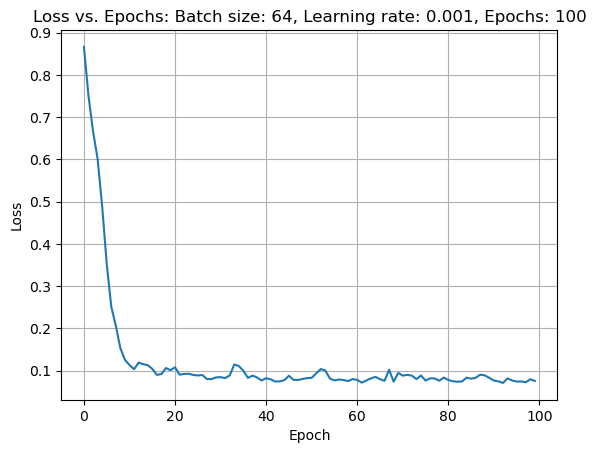

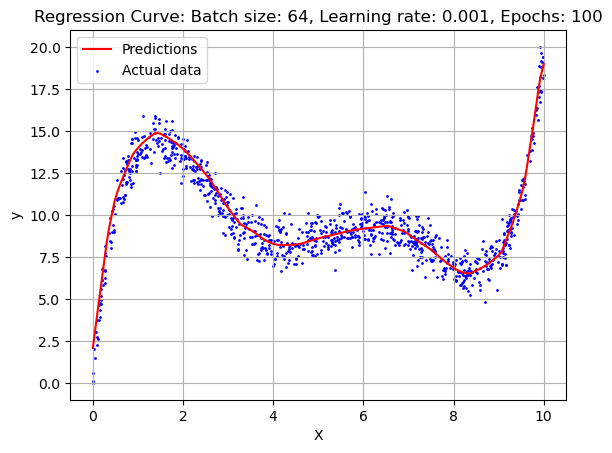

Training with num_epochs=100, batch_size=64, learning_rate=0.0001
Epoch 1/100, Loss: 0.9392
Epoch 2/100, Loss: 0.8736
Epoch 3/100, Loss: 0.8289
Epoch 4/100, Loss: 0.7828
Epoch 5/100, Loss: 0.7636
Epoch 6/100, Loss: 0.7349
Epoch 7/100, Loss: 0.7077
Epoch 8/100, Loss: 0.7029
Epoch 9/100, Loss: 0.6710
Epoch 10/100, Loss: 0.6362
Epoch 11/100, Loss: 0.6150
Epoch 12/100, Loss: 0.6018
Epoch 13/100, Loss: 0.5560
Epoch 14/100, Loss: 0.5317
Epoch 15/100, Loss: 0.5075
Epoch 16/100, Loss: 0.4872
Epoch 17/100, Loss: 0.4564
Epoch 18/100, Loss: 0.4306
Epoch 19/100, Loss: 0.4017
Epoch 20/100, Loss: 0.3820
Epoch 21/100, Loss: 0.3591
Epoch 22/100, Loss: 0.3341
Epoch 23/100, Loss: 0.3149
Epoch 24/100, Loss: 0.2923
Epoch 25/100, Loss: 0.2801
Epoch 26/100, Loss: 0.2507
Epoch 27/100, Loss: 0.2451
Epoch 28/100, Loss: 0.2246
Epoch 29/100, Loss: 0.2153
Epoch 30/100, Loss: 0.2026
Epoch 31/100, Loss: 0.1903
Epoch 32/100, Loss: 0.1775
Epoch 33/100, Loss: 0.1683
Epoch 34/100, Loss: 0.1560
Epoch 35/100, Loss: 0.150

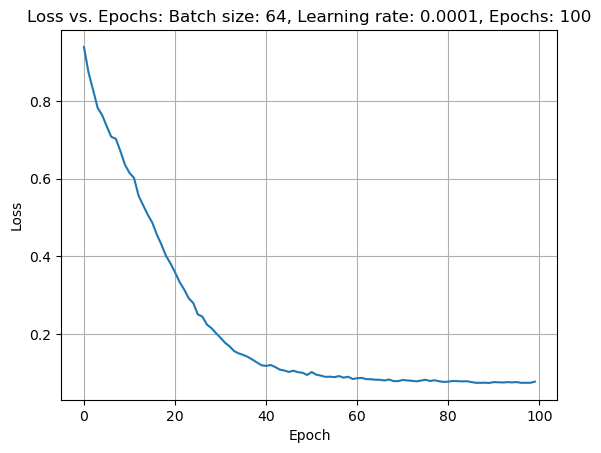

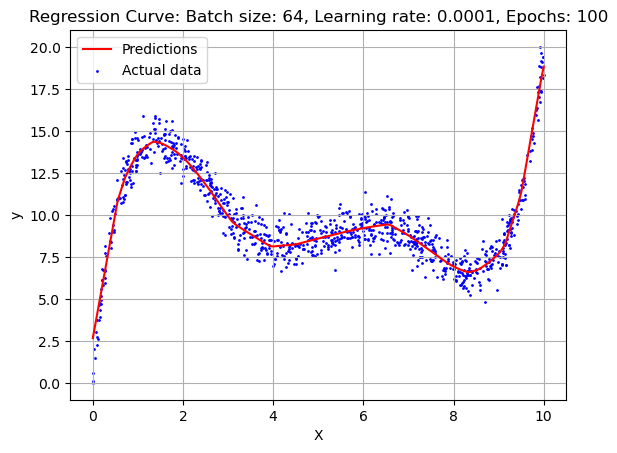

Training with num_epochs=100, batch_size=128, learning_rate=0.01
Epoch 1/100, Loss: 1.5716
Epoch 2/100, Loss: 0.8536
Epoch 3/100, Loss: 0.7522
Epoch 4/100, Loss: 0.6195
Epoch 5/100, Loss: 0.5274
Epoch 6/100, Loss: 0.3455
Epoch 7/100, Loss: 0.2803
Epoch 8/100, Loss: 0.2513
Epoch 9/100, Loss: 0.1540
Epoch 10/100, Loss: 0.1123
Epoch 11/100, Loss: 0.0918
Epoch 12/100, Loss: 0.1152
Epoch 13/100, Loss: 0.1051
Epoch 14/100, Loss: 0.1323
Epoch 15/100, Loss: 0.1332
Epoch 16/100, Loss: 0.1382
Epoch 17/100, Loss: 0.1123
Epoch 18/100, Loss: 0.1138
Epoch 19/100, Loss: 0.1103
Epoch 20/100, Loss: 0.0895
Epoch 21/100, Loss: 0.0909
Epoch 22/100, Loss: 0.0832
Epoch 23/100, Loss: 0.0780
Epoch 24/100, Loss: 0.0776
Epoch 25/100, Loss: 0.0794
Epoch 26/100, Loss: 0.1115
Epoch 27/100, Loss: 0.1385
Epoch 28/100, Loss: 0.1070
Epoch 29/100, Loss: 0.0965
Epoch 30/100, Loss: 0.0806
Epoch 31/100, Loss: 0.0782
Epoch 32/100, Loss: 0.0809
Epoch 33/100, Loss: 0.0866
Epoch 34/100, Loss: 0.0901
Epoch 35/100, Loss: 0.0879

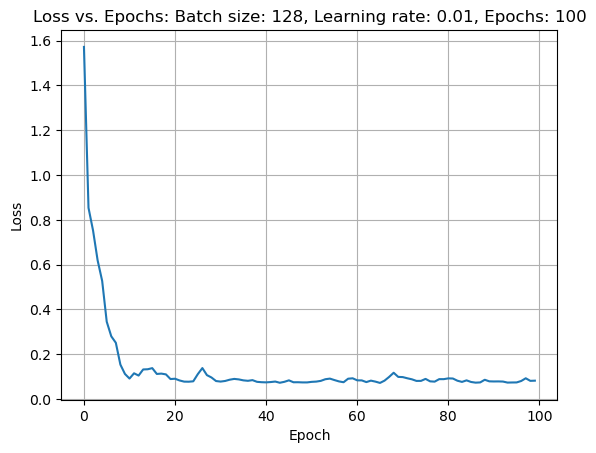

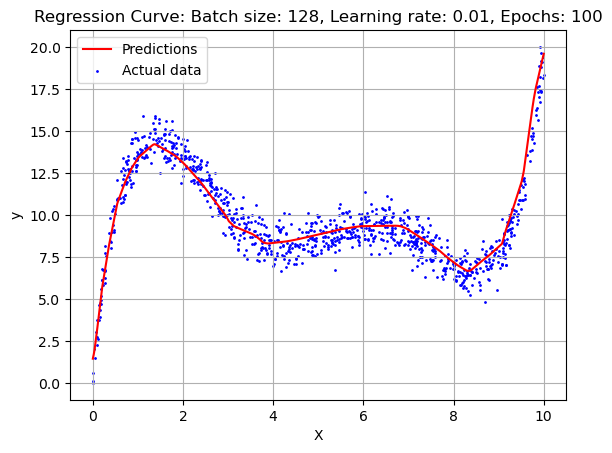

Training with num_epochs=100, batch_size=128, learning_rate=0.001
Epoch 1/100, Loss: 0.8893
Epoch 2/100, Loss: 0.7767
Epoch 3/100, Loss: 0.7084
Epoch 4/100, Loss: 0.6422
Epoch 5/100, Loss: 0.5615
Epoch 6/100, Loss: 0.4524
Epoch 7/100, Loss: 0.3686
Epoch 8/100, Loss: 0.2648
Epoch 9/100, Loss: 0.2048
Epoch 10/100, Loss: 0.1619
Epoch 11/100, Loss: 0.1412
Epoch 12/100, Loss: 0.1221
Epoch 13/100, Loss: 0.1080
Epoch 14/100, Loss: 0.1040
Epoch 15/100, Loss: 0.0897
Epoch 16/100, Loss: 0.0890
Epoch 17/100, Loss: 0.0937
Epoch 18/100, Loss: 0.1123
Epoch 19/100, Loss: 0.1212
Epoch 20/100, Loss: 0.0885
Epoch 21/100, Loss: 0.0949
Epoch 22/100, Loss: 0.0894
Epoch 23/100, Loss: 0.0817
Epoch 24/100, Loss: 0.0899
Epoch 25/100, Loss: 0.0881
Epoch 26/100, Loss: 0.0957
Epoch 27/100, Loss: 0.0860
Epoch 28/100, Loss: 0.0878
Epoch 29/100, Loss: 0.0784
Epoch 30/100, Loss: 0.0815
Epoch 31/100, Loss: 0.0753
Epoch 32/100, Loss: 0.0757
Epoch 33/100, Loss: 0.0758
Epoch 34/100, Loss: 0.0759
Epoch 35/100, Loss: 0.080

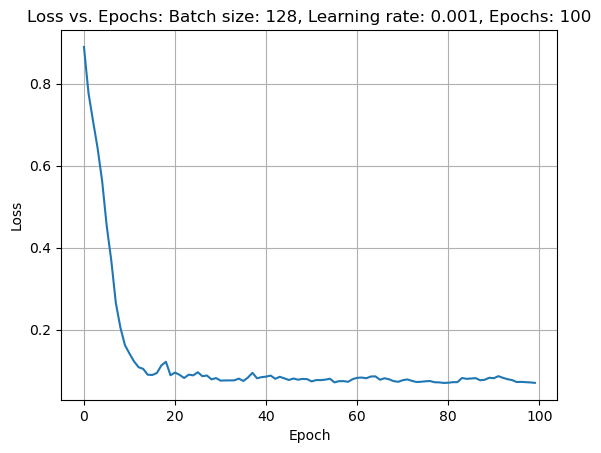

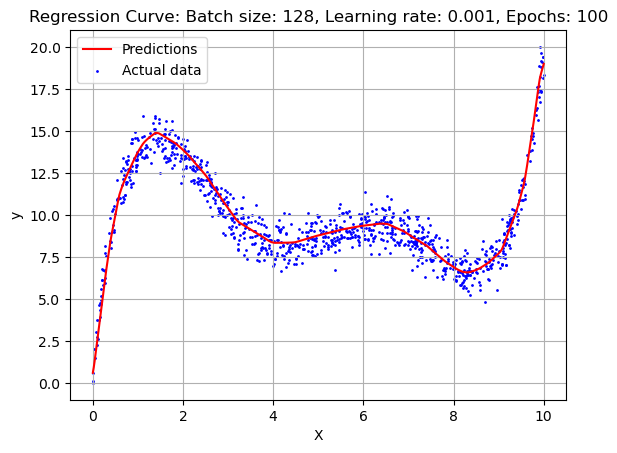

Training with num_epochs=100, batch_size=128, learning_rate=0.0001
Epoch 1/100, Loss: 0.9703
Epoch 2/100, Loss: 0.8971
Epoch 3/100, Loss: 0.8718
Epoch 4/100, Loss: 0.8373
Epoch 5/100, Loss: 0.8105
Epoch 6/100, Loss: 0.7937
Epoch 7/100, Loss: 0.7718
Epoch 8/100, Loss: 0.7565
Epoch 9/100, Loss: 0.7408
Epoch 10/100, Loss: 0.7245
Epoch 11/100, Loss: 0.7121
Epoch 12/100, Loss: 0.6952
Epoch 13/100, Loss: 0.6883
Epoch 14/100, Loss: 0.6722
Epoch 15/100, Loss: 0.6666
Epoch 16/100, Loss: 0.6490
Epoch 17/100, Loss: 0.6271
Epoch 18/100, Loss: 0.6174
Epoch 19/100, Loss: 0.6049
Epoch 20/100, Loss: 0.5879
Epoch 21/100, Loss: 0.5734
Epoch 22/100, Loss: 0.5596
Epoch 23/100, Loss: 0.5483
Epoch 24/100, Loss: 0.5284
Epoch 25/100, Loss: 0.5106
Epoch 26/100, Loss: 0.4959
Epoch 27/100, Loss: 0.4795
Epoch 28/100, Loss: 0.4622
Epoch 29/100, Loss: 0.4459
Epoch 30/100, Loss: 0.4264
Epoch 31/100, Loss: 0.4078
Epoch 32/100, Loss: 0.3996
Epoch 33/100, Loss: 0.3748
Epoch 34/100, Loss: 0.3598
Epoch 35/100, Loss: 0.34

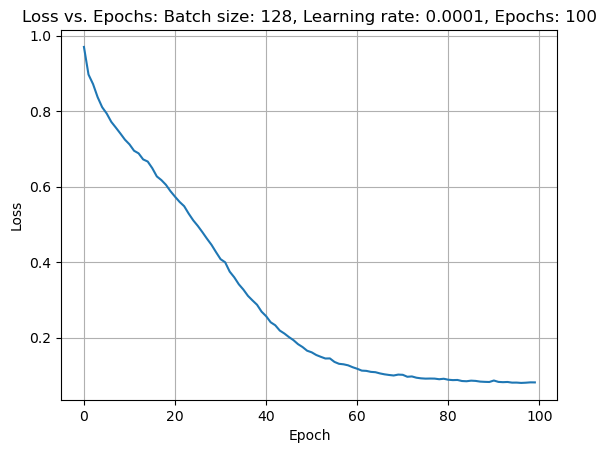

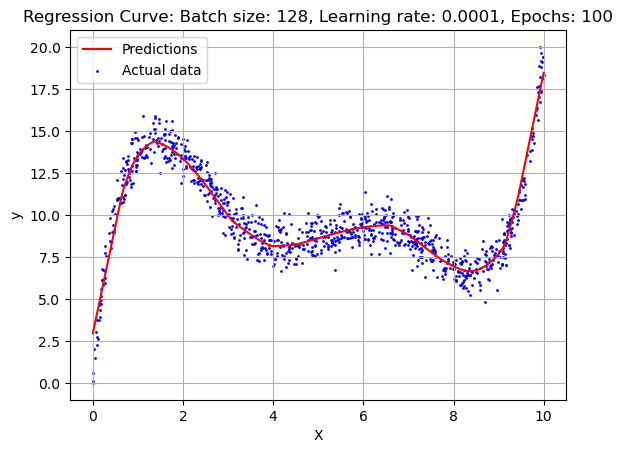

In [158]:
batchSizes = [32, 64, 128];
learningRates = [0.01, 0.001, 0.0001];
numEpochs = 100;

bestParams = hyperParamSearch(trainDataSet, batchSizes, learningRates, numEpochs);

Best params: {'num_epochs': 100, 'batch_size': 128, 'learning_rate': 0.001, 'losses': [0.8893244713544846, 0.7767327800393105, 0.7084243409335613, 0.6422423385083675, 0.5615421570837498, 0.45244481042027473, 0.3685959726572037, 0.26482891850173473, 0.20481255650520325, 0.161871038377285, 0.14120381325483322, 0.12211007531732321, 0.107973363250494, 0.10396681074053049, 0.08973469771444798, 0.08904359769076109, 0.0937220910564065, 0.11234855651855469, 0.12122984509915113, 0.0884743295609951, 0.09486731141805649, 0.08937577158212662, 0.0816612271592021, 0.08987489622086287, 0.08813980128616095, 0.09573745634406805, 0.08602657075971365, 0.08775721397250891, 0.07836239412426949, 0.08150237426161766, 0.07534180209040642, 0.07572962436825037, 0.07581300707533956, 0.07594552170485258, 0.08019816316664219, 0.07449052855372429, 0.08279294520616531, 0.0942321503534913, 0.081009391695261, 0.08375629223883152, 0.0850803516805172, 0.08758178818970919, 0.07975906133651733, 0.0846381620503962, 0.08075

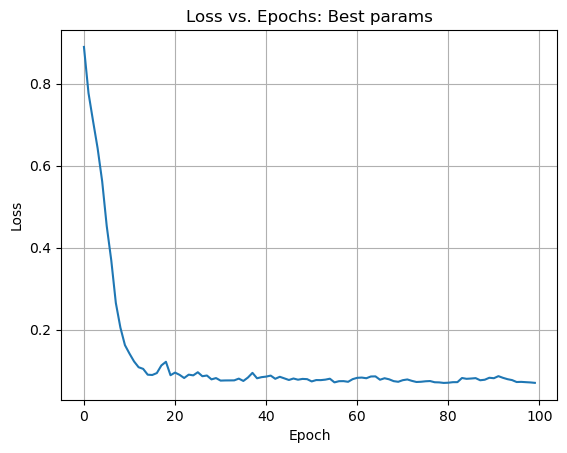

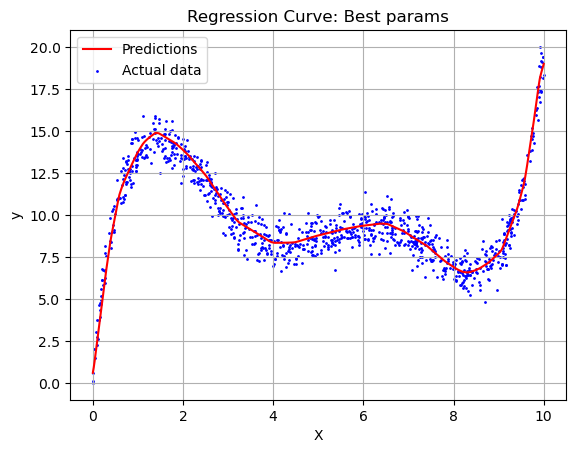

In [159]:
print(f"Best params: {bestParams}");
plotLossCurve(bestParams["losses"], "Best params");
plotRegressionCurve(bestParams["model"], "Best params");